In [1]:
import os
from os import mkdir, makedirs
from os.path import join,exists,basename,splitext
from glob import glob
import csv
import cv2
import re
import numpy as np
from sklearn.decomposition import IncrementalPCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

import seaborn as sns

import tensorflow as tf
from tensorboard.plugins import projector

from natsort import natsorted

# Create Image Sprite

In [2]:
# Taken from: https://github.com/tensorflow/tensorflow/issues/6322
def images_to_sprite(data):
    """Creates the sprite image along with any necessary padding
    Args:
      data: NxHxW[x3] tensor containing the images.
    Returns:
      data: Properly shaped HxWx3 image with any necessary padding.
    """
    if len(data.shape) == 3:
        data = np.tile(data[...,np.newaxis], (1,1,1,3))
    data = data.astype(np.float32)
    min = np.min(data.reshape((data.shape[0], -1)), axis=1)
    data = (data.transpose(1,2,3,0) - min).transpose(3,0,1,2)
    max = np.max(data.reshape((data.shape[0], -1)), axis=1)
    data = (data.transpose(1,2,3,0) / max).transpose(3,0,1,2)
    # Inverting the colors seems to look better for MNIST
    #data = 1 - data

    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, 0),
            (0, 0)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant',
            constant_values=0)
    # Tile the individual thumbnails into an image.
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3)
            + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    data = (data * 255).astype(np.uint8)
    return data


def create_image_sprite(list_path_frames, path_logs, method, image_size=(224,224)):
    image_sprite_filename = join(path_logs, 'image_sprite_{}.png'.format(method))
    
    if not exists(image_sprite_filename):        
        image_data = []
        for path_frame in list_path_frames:
            image = cv2.imread(path_frame,1)
            image = cv2.resize(image, image_size) 
            image_data.append(image)

        image_data = np.array(image_data)
        image_sprite = images_to_sprite(image_data)
        cv2.imwrite(image_sprite_filename, image_sprite)
    return image_sprite_filename
    
    
def create_metadata_file(list_path_frames, path_logs, method):
    metadata_filename = join(path_logs, 'metadata_{}.tsv'.format(method))
    
    if not exists(metadata_filename):        
        metadata_file = open(metadata_filename, 'w')        

        for path_frame in list_path_frames:    
            filename =  basename(path_frame)
            metadata_file.write('{}\n'.format(filename))    
        metadata_file.close()
    return metadata_filename
       
    
def create_config_file(path_logs, tensor_filename, features, image_sprite_filename, metadata_filename, image_sprite_size):    

    with open(tensor_filename, 'w') as fw:
        csv_writer = csv.writer(fw, delimiter='\t')
        csv_writer.writerows(features)

    config = projector.ProjectorConfig()
    # One can add multiple embeddings.
    embedding = config.embeddings.add()
    embedding.tensor_path = tensor_filename
    # Link this tensor to its metadata file (e.g. labels).
    embedding.metadata_path = metadata_filename
    # Comment out if you don't want sprites
    embedding.sprite.image_path = image_sprite_filename
    embedding.sprite.single_image_dim.extend([image_sprite_size[0], image_sprite_size[1]])
    # Saves a config file that TensorBoard will read during startup.
    projector.visualize_embeddings(path_logs, config)

In [3]:
def ipca_fit_transform(list_path_frames, final_size = (640,480)):        
    features = None
    batch_size = 103
    ipca = IncrementalPCA(n_components=100)
    i = 0
        
    # Incremental PCA partial fit
    print("[INFO] Incremental PCA - partial fit")
    for path_frame in list_path_frames:
        image = cv2.imread(path_frame,1)    
        image = cv2.resize(image, final_size)    
        image = image/255
        image = np.reshape(image, (1,-1))

        if features is None:
            features = image
        else:
            features = np.concatenate((features, image),axis=0)

        if features.shape[0] == batch_size:
            i+=1
            print("[INFO] Partial fit of block {}/{}".format(i,int(len(list_path_frames)/batch_size)))
            ipca.partial_fit(features)
            features = None

    if features is not None:
        ipca.partial_fit(features)
    
    print("Accumulated variance: {}".format(np.sum(ipca.explained_variance_ratio_)))
    
    # Incremental PCA transform
    print("[INFO] Incremental PCA - transform")
    features_transform = None
    for i,path_frame in enumerate(list_path_frames):
        print("[INFO] Processing image {}/{}".format(i+1,len(list_path_frames)))
        image = cv2.imread(path_frame,1)    
        image = cv2.resize(image, final_size)    
        image = image/255
        image = np.reshape(image, (1,-1))
        image_transform = ipca.transform(image)

        if features_transform is None:
            features_transform = image_transform
        else:
            features_transform = np.concatenate((features_transform, image_transform),axis=0)
            
    return features_transform


def extract_pca(list_path_frames, filename_features):
    if not exists(filename_features):
        features = ipca_fit_transform(list_path_frames)
        with open(filename_features, 'wb') as f:
            np.save(f, features)
    else:
        with open(filename_features, 'rb') as f:
            features = np.load(f)
        
    print(features.shape)    
    return features

In [4]:
path_root = os.getcwd()
path_videos = join(path_root, "videos_processed")
path_frames = join(path_root,"videos_frames")
path_crop_frames = join(path_root,"videos_frames_crop")

list_path_frames = glob(join(path_crop_frames,"*.png"))
list_path_frames = natsorted(list_path_frames, key=lambda y: y.lower())
len(list_path_frames)

927

In [ ]:
method = "pca"
path_logs = join(path_root,"logs",method)
if not exists(path_logs):
    makedirs(path_logs)

image_sprite_size = (224,224)
    
image_sprite_filename = create_image_sprite(list_path_frames, path_logs, method, image_sprite_size)
metadata_filename = create_metadata_file(list_path_frames, path_logs, method)

filename_features = join(path_root,'features_{}.npy'.format(method))
features = extract_pca(list_path_frames, filename_features)

tensor_filename = join(path_logs, 'features_{}.tsv'.format(method))
create_config_file(path_logs, tensor_filename, features, image_sprite_filename, metadata_filename, image_sprite_size)

In [15]:
from scipy import stats
import numpy as np
import cv2
import os
from os.path import exists

features = None
final_size = (640,480)
for path_frame in list_path_frames:
    image = cv2.imread(path_frame,1)    
    image = cv2.resize(image, final_size)
    image = image/255
    image = np.reshape(image, (1,-1))
    image_stats = stats.describe(image, axis=1)
    image_stats = np.transpose(np.stack([image_stats.mean,image_stats.variance,image_stats.skewness,image_stats.kurtosis]))
   
    if features is None:
        features = image_stats
    else:
        features = np.concatenate((features, image_stats),axis=0)    


    
print(features.shape)

(927, 4)


In [51]:
from scipy import stats
import numpy as np
import cv2
import os
from os.path import exists
import mahotas as mt
from skimage.util.shape import view_as_windows

features = None
final_size = (640,480)
kernel_size = (160,160)
stride = 160

for path_frame in list_path_frames:
    image = cv2.imread(path_frame,0)
    image = cv2.resize(image, final_size)
    
    image_patches = view_as_windows(image, kernel_size, step=stride)
    image_patches = image_patches.reshape(-1,image_patches.shape[-1],image_patches.shape[-2])

    image_textures = []
    for patch in image_patches:        
        patch_textures = mt.features.haralick(patch).mean(axis=0)        
        image_textures.append(patch_textures)
    image_textures = np.stack(image_textures,axis=0).flatten()
    
    textures = np.reshape(image_textures, (1,-1))    
   
    if features is None:
        features = textures
    else:
        features = np.concatenate((features, textures),axis=0)    
        
    print(features.shape)

(1, 156)
(2, 156)
(3, 156)
(4, 156)
(5, 156)
(6, 156)
(7, 156)
(8, 156)
(9, 156)
(10, 156)
(11, 156)
(12, 156)
(13, 156)
(14, 156)
(15, 156)
(16, 156)
(17, 156)
(18, 156)
(19, 156)
(20, 156)
(21, 156)
(22, 156)
(23, 156)
(24, 156)
(25, 156)
(26, 156)
(27, 156)
(28, 156)


KeyboardInterrupt: 

In [40]:
print(features.shape)

(927, 13)


In [39]:
(features - features.min(axis=0))/(features.max(axis=0) - features.min(axis=0))

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 927 samples in 0.002s...
[t-SNE] Computed neighbors for 927 samples in 0.013s...
[t-SNE] Computed conditional probabilities for sample 927 / 927
[t-SNE] Mean sigma: 19.435933
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.533936
[t-SNE] KL divergence after 1000 iterations: 0.321027


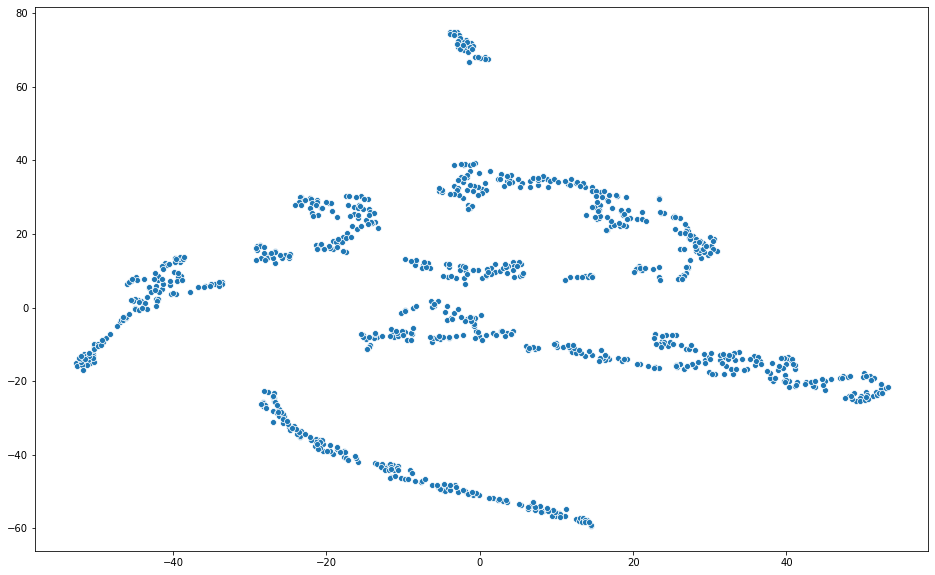

In [42]:
tsne = TSNE(n_components=2, verbose=1, perplexity=20, n_iter=1000)
tsne_results = tsne.fit_transform(features)

plt.figure(figsize=(16,10))
sns.scatterplot(
    x=tsne_results[:,0], y=tsne_results[:,1],
    palette=sns.color_palette("hls", 10),
    legend="full"
)
plt.show()